&nbsp;

# 4. Optimization 
Optimization is the process of finding the best combination of hyperparameters that minimize your loss function. Optimizing your machine learning algorithms is an important step when making predictions because not every machine learning problem is the same and in comparison, not every solution will be appropriate. Finding the best hyperparameters for your specific solution will ensure that your model will be optimized to your specific problem and will accurately make predictions with a more robust mapping function. 

In [1]:
# Standard libraries. 
import pandas as pd
import numpy as np 
import os
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# Importing our functions. 
import functions
import visuals

# Importing emsemble models. 
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

# Import transformers.  
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder, FunctionTransformer

# Renders plotly figs into svg static images. 
import plotly.io as pio
pio.renderers.default = "svg"

In [2]:
root = os.getcwd() # Setting root directory as cwd. 
df = pd.read_csv(r"{}\train_PriceCapRemoved.csv".format(root)) # Importing the train set.
df.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.78570,20.0,3.97,0,0.647,7.014,84.6,2.1329,5,264.0,13.0,384.07,14.79,30.7
1,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4


### Section A: Dimensionality Reduction
Principle Component Analysis (PCA) is a feature elimination technqiue used to speed up processing time during training. The main idea is to get rid of similiar features whilst still retaining enough information of the feature space. Generally, we want to preserve a an explained variance of 95-99%. 

**A.1: Choosing n_components**<br>
The first step into conducting PCA is to choose the optimal "n_components", which is basically saying how many features would you like PCA to create. We can find the optinal "n_components" by applying the Elbow Method.

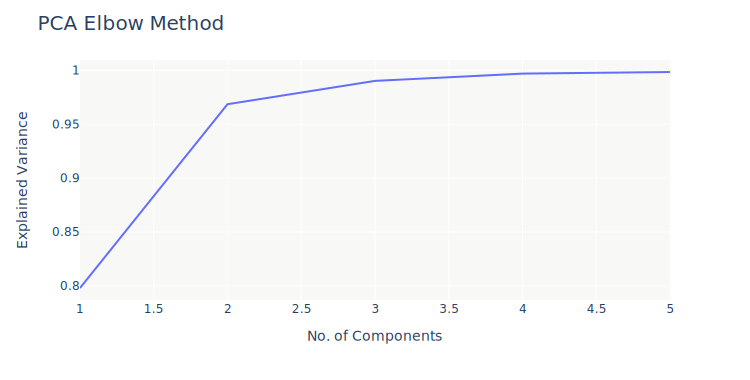

In [3]:
# Splitting the data. 
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# Store variance output. 
explained_variance = list()

# Cycle through explained variance for each no. of features. 
# The reason we use a range of (1, 6) is because the eblow is too difficult to see if we use all 711 features. 
for x in range(1, 6):
    pca = PCA(n_components=x)
    pca.fit(X)    
    explained_variance.append(np.sum(pca.explained_variance_ratio_))

# Plotting explained variance against no. of components. 
fig = px.line(x=range(1,6), y=explained_variance)
fig.update_layout(title='PCA Elbow Method',
                       xaxis_title='No. of Components',  
                       yaxis_title='Explained Variance', height=380, width=750, plot_bgcolor='#F8F8F6', title_font_size=20, 
                       title_font_family='Arial Black') 
fig.show()

* Based on the elbow method we will choose 2 principle components, as it explains 97% of the data.

In [4]:
# The model_evaluation() class sets up the pipeline to transform the data then returns a cross validated score. 
GBR_pca = functions.model_evaluation()
GBR_pca.preprocessing(df)
GBR_pca.add_pipe_component("pca", PCA(n_components=2))
GBR_pca.add_pipe_component("clf", GradientBoostingRegressor())
GBR_pca.cross_validation(df)

print("Our PCA transformed dataset scored an MSE of: %.2f" % (GBR_pca.cv_result))

Our PCA transformed dataset scored an MSE of: 45.27


* Hold on a second, how come our MSE saw an exponential increase?
* It seems even though 2 principle components retained enough information, the performance of the dataset deteroriated. So what we can do is iterate over a range of n_components and use the best score that does not degrade our model performance too harshly.

In [5]:
# Store results from each iteration of n_components. 
pca_resultsGBR = dict()
pca_resultsRFR = dict()
pca_resultsXGB = dict()

**A.2: Gradient Boosting Regressor PCA**<br>
Let's now use our GBR model and iterate over n_components and find the lowest MSE.

In [6]:
functions.optimal_components(GradientBoostingRegressor(), pca_resultsGBR, df) 
new_value = min(pca_resultsGBR, key=pca_resultsGBR.get)
print("The optimal PCA configuration for Gradient Boosting Regressior is: n_component=%s, with an MSE of %.2f: " 
      % (new_value, pca_resultsGBR[str(new_value)]))

The optimal PCA configuration for Gradient Boosting Regressior is: n_component=11, with an MSE of 11.51: 


**A.3: Random Forest Regressor PCA**<br>
Let's now use our RFR model and iterate over n_components and find the lowest MSE.

In [7]:
functions.optimal_components(RandomForestRegressor(), pca_resultsRFR, df) 
new_value = min(pca_resultsRFR, key=pca_resultsRFR.get)
print("The optimal PCA configuration for Random Forest Regressor is: n_component=%s, with an MSE of %.2f: "
      % (new_value, pca_resultsRFR[str(new_value)]))

The optimal PCA configuration for Random Forest Regressor is: n_component=13, with an MSE of 11.99: 


**A.4: XGB Regressor PCA**<br>
Let's now use our XGB model and iterate over n_components and find the lowest MSE.

In [8]:
functions.optimal_components(XGBRegressor(), pca_resultsXGB, df) 
new_value = min(pca_resultsXGB, key=pca_resultsXGB.get)
print("The optimal PCA configuration for XGB Regressor is: n_component=%s, with an MSE of %.2f: " 
      % (new_value, pca_resultsXGB[str(new_value)]))

The optimal PCA configuration for XGB Regressor is: n_component=13, with an MSE of 12.56: 


| Model | Model Type | n_components | MSE |
|---------|---------|---------|---------|
| **Gradient Boosting Regressor** | PCA Gradient Boosting Regressor | 11 |11.52 |
| **Random Forest Regressor** | PCA Random Forest Regressor | 13 |12.30 |
| **XGB Regressor** | PCA XGB Regressor | 13 |12.56 |

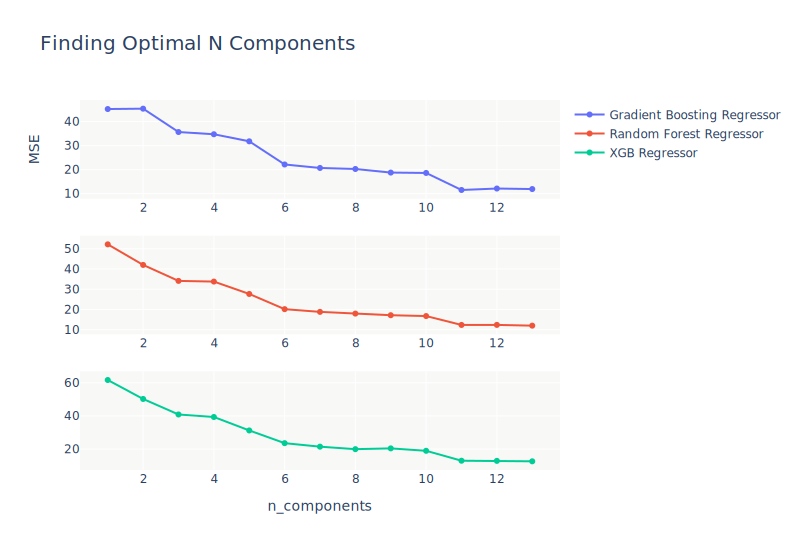

In [9]:
# Setting up axes for each subplot.  
x_axis  = list(range(1,51))
y_axisGBR = list(pca_resultsGBR.values())
y_axisRFR = list(pca_resultsRFR.values())
y_axisXGB = list(pca_resultsXGB.values())

# Plotting results. 
visuals.n_components_plot(xaxis=x_axis, yGBR=y_axisGBR, yRFR=y_axisRFR, yXGB=y_axisXGB)

### Section B: Grid Search Cross Validation
Grid Search Cross Validation is a hyperparameter tuning technique where the user specifies a "parameter grid" (a list of parameters provided with the values they want to test) then the algorithm will evaluate each and every combination using cross validation before outputting the best feature combination.

**B.1: Gradient Boosting Regressor**<br>
Let's now implement the grid search cross validation algorithm to our Gradient Boosting model to find the best combination of hypertuned parameters.

In [10]:
# Creating our class instance for our GBR. 
GBR_gs = functions.model_evaluation() 

# Adding parameter grid. 
GBR_gs.add_params_component('n_estimators', [50, 250, 500])
GBR_gs.add_params_component('min_samples_split', [2, 30, 50])
GBR_gs.add_params_component('max_depth', [2, 20, 50])
GBR_gs.add_params_component('learning_rate', [0.1, 0.01, 0.001])
# Evaluate using grid search. 
GBR_gs.grid_search(X, y, GradientBoostingRegressor())

Best: -8.057536 using {'learning_rate': 0.1, 'max_depth': 20, 'min_samples_split': 50, 'n_estimators': 500}


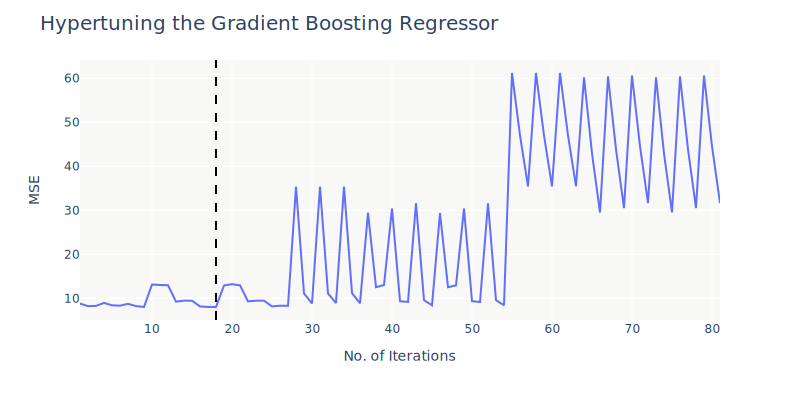

In [11]:
# Plotting results. 
visuals.grid_search_plot(GBR_gs, "Gradient Boosting Regressor")

* At around the 9th iteration we found our local MSE minima at a value of 8.05.
* There also seems to be a recurring pattern that increases in size at the 55th iteration.

**B.2: Random Forest Regressor**<br>
Let's now implement the grid search cross validation algorithm to our Random Forest model to find the best combination of hypertuned parameters. Remember that our Random Forest and XGB Regressor's performed the best with log scaled data, so we must first transform our dataset before we initate grid search.

In [12]:
log = FunctionTransformer(np.log1p) # Creating our log instance.
logFeatures = log.fit_transform(X) # Transforming the data.
dfLog = pd.DataFrame(data=logFeatures, columns=list(X.columns)) # Store results in dataframe.
dfLog.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.579810,3.044522,1.60342,0.0,0.498955,2.081190,4.449685,1.141959,1.791759,5.579730,2.639057,5.953425,2.759377
1,0.060747,0.000000,2.55955,0.0,0.452985,2.027227,4.249923,1.246630,0.693147,5.613128,3.091042,5.973784,2.367436


In [13]:
# Creating our class instance for RFR. 
RFR_gs = functions.model_evaluation()

# Adding parameter grid.
RFR_gs.add_params_component('n_estimators', [50, 250, 500])
RFR_gs.add_params_component('min_samples_split', [2, 30, 50])
RFR_gs.add_params_component('min_samples_leaf', [2, 10, 25])
RFR_gs.add_params_component('max_depth', [2, 20, 50])
# Evaluate using grid search. 
RFR_gs.grid_search(dfLog, y, RandomForestRegressor())

Best: -9.111858 using {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}


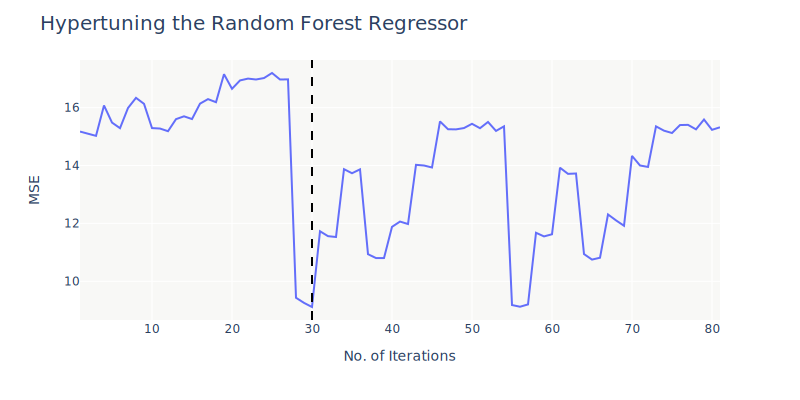

In [14]:
# Plotting results. 
visuals.grid_search_plot(RFR_gs, "Random Forest Regressor")

* Just like our Gradient Boosting Rergessor, there seems to be a recurring pattern that occurs after 30 iterations.
* The local MSE minima was found at 9.03.

**B.3: XGB Regressor**<br>
And finally let's hypertune our XGB Regressor.

In [15]:
# Creating our class instance for RFR. 
XGB_gs = functions.model_evaluation()

# Adding parameter grid.
XGB_gs.add_params_component('n_estimators', [50, 250, 500])
XGB_gs.add_params_component('min_child_weight', [1, 5, 15])
XGB_gs.add_params_component('max_depth', [2, 20, 50])
XGB_gs.add_params_component('learning_rate', [0.1, 0.01, 0.001])
# Evaluate using grid search. 
XGB_gs.grid_search(dfLog, y, XGBRegressor())

Best: -7.312472 using {'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 15, 'n_estimators': 500}


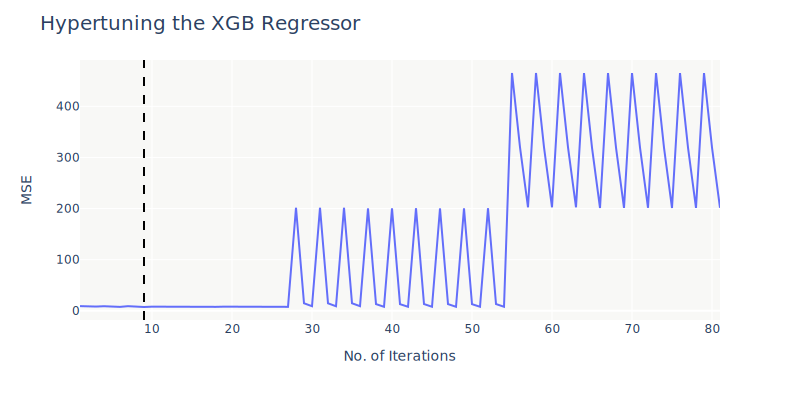

In [16]:
# Plotting results. 
visuals.grid_search_plot(XGB_gs, "XGB Regressor")

* It seems like the XGB Regressor outputted an identical pattern of results as our Gradient Boosting Regressor.
* The local minima MSE value was found at iteration 8 with an MSE of 7.31

**B.4: Conclusion**<br>
In conclusion our dataset is small enough to process quickly without the need to dimensionality reduction. In terms of the grid search algorithm our XGBoost Regressor scored the best result with a MSE of 7.31 followed by our Gradient Boosting Regressor with a score of 8.0b5 and finally our Random Forest with an MSE of 9.03.

&nbsp;

| Model | GridSearch CV Score | Final Model | 
|---------|---------|---------|
| **Gradient Boosting Regressor** |8.05 |GradientBoostingRegressor(learning_rate=0.1, max_depth=2, min_samples_split=50, n_estimators=500) | 
| **Random Forest Regressor** |9.03 |RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=500) | 
| **XGB Regressor** |7.31 |XGBRegressor(learning_rate=0.1, max_depth=2, min_child_weight=15, n_estimators=500) | 

&nbsp;

&nbsp;
**Author:** Aaron Chew&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **|** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Date Published:** 11/08/2022 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**|** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Email:** aaronsamuelchew@gmail.com &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**|**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **GitHub:** https://github.com/aaron-chew  